In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(784, 128, bias=True)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(128, 64, bias=True)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 10, bias=True)
        self.activation3 = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        return x

In [3]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.view(data.shape[0], -1).to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [4]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.view(data.shape[0], -1).to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

In [5]:
def show_confusion_matrix():
    model.eval()
    
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.shape[0], -1).to(DEVICE)
            output = model(data)
            
            output = output.data.max(1, keepdim=True)[1].cpu().numpy().reshape(-1)
            y_pred.extend(output)
            
            target = target.cpu().numpy().reshape(-1)
            y_true.extend(target)

    classes = [str(i) for i in range(10)]
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    plt.show()

In [6]:
EPOCHS = 10
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 1000
LR = 0.01
LOG_INTERVAL = 100
RANDOM_SEED = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(RANDOM_SEED)

In [7]:
train_dataset = MNIST('data/', train=True, download=True, transform=ToTensor())
test_dataset = MNIST('data/', train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=True)

In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

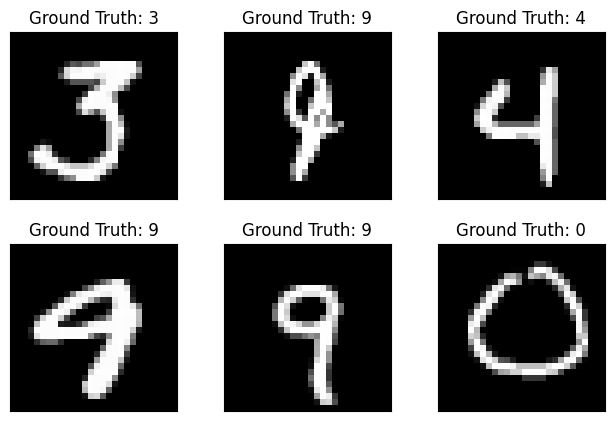

In [9]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()

In [10]:
model = Net().to(DEVICE)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

In [11]:
print(model)

Net(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=64, out_features=10, bias=True)
  (activation3): LogSoftmax(dim=1)
)


In [12]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(EPOCHS + 1)]

In [13]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309234
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.282424
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.251280
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.178790
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.091611
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.844055
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.623892
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.382969
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.148151
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.819669

Test set: Avg. loss: 0.0009, Accuracy: 7939/10000 (79%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.077937
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.648780
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.762534
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.662596
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.474133
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.533889
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.470959
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.483338
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.539015
Trai

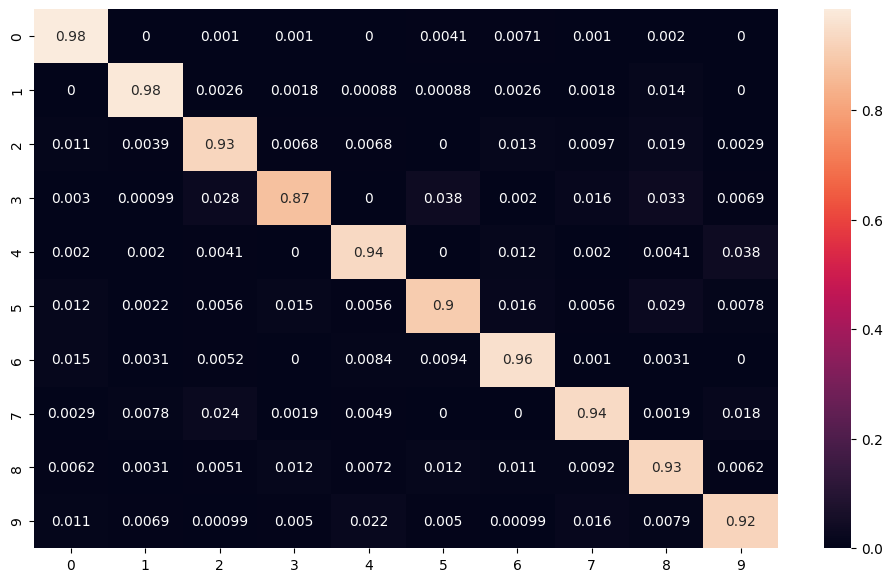

In [14]:
show_confusion_matrix()